# Introduction

This Notebook will guide you through understanding how to use Keras for OCR experimentations with CTC Loss.

It was partially inspired by [the Keras' team example](https://github.com/keras-team/keras/blob/master/examples/image_ocr.py).

# Making the data

In [1]:
from os.path import join, isfile

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import cv2

We will use data given by the ENSC on Bodmer's manuscript.

Files are named as "{0}\_{1}.{extension}" where {0} is the page number and {1} is the line number code.

The file _list.txt_ lists all existing data tags.

In [2]:
path = "../data/books/bodmer/full/"

with open(join(path, "list.txt"), 'r') as f:
    tags =  [line.rstrip() for line in f.readlines()]

Before anything else, read data labels and remove empty ones.

In [3]:
Y_texts = []
for i, tag in enumerate(tags):
    with open(path + '{}.txt'.format(tag)) as f:
        y_text = f.readline().rstrip()
        Y_texts.append(y_text)

In [4]:
tags, Y_texts = map(list, zip(*filter(lambda x: x[1] != '', zip(tags, Y_texts))))

Secondly build the alphabet from data.

- *charset* is a dict with items (char, occurences)
- *alphabet* is a string with all characters ordered

In [5]:
def update_charset(y_texts):
        charset = {}
        for y_text in Y_texts:
            for char in y_text:
                if char not in charset:
                    charset[char] = 0
                charset[char] += 1
        alphabet = ''.join(map(lambda x:x[0], sorted(charset.items(), key=lambda x:x[1], reverse=True)))
        return charset, alphabet

In [6]:
char_n_threshold = 5

charset, alphabet = update_charset(Y_texts)
while any([char_n < char_n_threshold for char_n in charset.values()]):
    chars_to_delete = [char for char, char_n in charset.items() if char_n < char_n_threshold]
    tags, Y_texts = map(list, zip(*filter(lambda x: not any([char_to_delete in x[1] for char_to_delete in chars_to_delete]), zip(tags, Y_texts))))
    charset, alphabet = update_charset(Y_texts)

We can encode those texts into categorical labels :

In [7]:
def text_to_label(text):
    return [alphabet.find(c) for c in text]

In [8]:
Y = [text_to_label(y_text) for y_text in Y_texts]

Then load image files.

In [9]:
imgs = [imread(join(path, '{}.png'.format(tag))) for tag in tags]

Resize images in order to have the same height and only gray scale.

In [10]:
img_height = 150

X = []

for i, (tag, img) in enumerate(zip(tags, imgs)):
    x = img[:, :, :-2].mean(axis=2) if len(img.shape) > 2 else img
    img_height_in, img_width_in = x.shape
    img_width_out = int(img_width_in * (img_height/img_height_in))
    # open cv is (width, height)
    x = x.transpose()
    x_resized = cv2.resize(x, dsize=(img_height, img_width_out), interpolation=cv2.INTER_LINEAR)
    x_resized = x_resized.transpose()
    X.append(x_resized)

CTC Loss will need some more data :

- input data width
- label lengths

In [11]:
X_widths = [x.shape[1] for x in X]
X_widths_max = max(X_widths)

In [12]:
Y_lens = [len(y_text) for y_text in Y_texts]
Y_lens_max = max(Y_lens)

Moreover the input needs to be numpy arrays, which need to have fixed dimensions.

In [13]:
X = np.array([np.hstack([x, np.ones((img_height, X_widths_max-width))]) for x, width in zip(X, X_widths)])

The input needs to have `ndim == 4` and to be width-first.

In [14]:
X = np.swapaxes(X, 1, 2)[:, :, :, np.newaxis]

In [15]:
X_widths = np.array(X_widths)

In [16]:
Y = np.array([np.hstack([y, len(alphabet)*np.ones((Y_lens_max-l))]) for y, l in zip(Y, Y_lens)], dtype=np.int)

In [17]:
Y_lens = np.array(Y_lens)

Let us verify the input data :

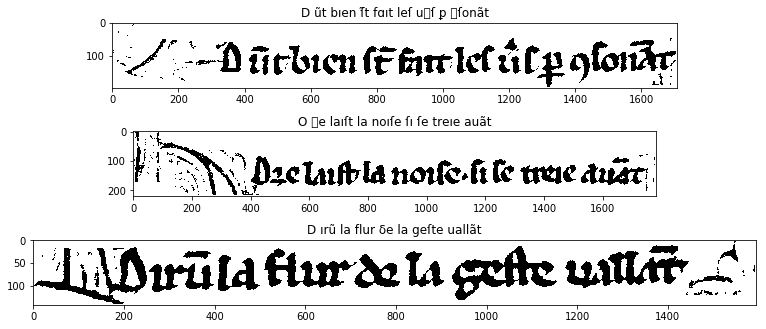

In [18]:
plt.figure(figsize=(15,15))

for i, (x, y_text) in enumerate(list(zip(imgs, Y_texts))[:3]):
    plt.subplot(10, 1, i+1)
    plt.title(y_text)
    plt.imshow(x, cmap="gray")

plt.tight_layout()

# Train the model

We will now train a Neural Network with the data we just extracted.

We can do this thanks to the very convenient *Connectionist Temporal Classification Loss* (CTC Loss) which works best on temporal data. Indeed the width in every line can be seen as a temporal sequence, from left to right.

In [19]:
import keras
from keras import backend as K
from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, GRU, LSTM, Dense, Activation, Lambda, Reshape
from keras.optimizers import SGD

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


I used Tensorflow in this Notebook, be carefull of X's shape if you use other backends.

In [20]:
if K.image_data_format() == 'channels_first':
    input_shape = (1, X_widths_max, img_height)
else:
    input_shape = (X_widths_max, img_height, 1)

We create the layers for the model.

In [21]:
# INPUT
inputs = Input(name='inputs', shape=input_shape, dtype='float32')
inputs_width = Input(name='inputs_width', shape=[1], dtype='int64')

# LABELS
labels = Input(name='labels', shape=[Y_lens_max], dtype='float32')
labels_length = Input(name='labels_length', shape=[1], dtype='int64')

# CNN
conv1 = Conv2D(16, (5, 5), padding='same', activation='relu', name='conv1')(inputs)
maxpool1 = MaxPooling2D(2, name='maxpool1')(conv1)
conv2 = Conv2D(16, (5, 5), padding='same', activation='relu', name='conv2')(maxpool1)
maxpool2 = MaxPooling2D(2, name='maxpool2')(conv2)
conv3 = Conv2D(16, (5, 5), padding='same', activation='relu', name='conv3')(maxpool2)
maxpool3 = MaxPooling2D(2, name='maxpool3')(conv3)
reshape1 = Reshape((-1, 16*(img_height//(2**3))), name='reshape1')(maxpool3)

# RNN
lstm1 = LSTM(500, return_sequences=True, kernel_initializer='he_normal', name='lstm1')(reshape1)
## TODO add backward RNN

# CHAR ACTIVATION
dense1 = Dense(len(alphabet)+1, name='dense1')(lstm1)
softmax1 = Activation('softmax', name='softmax1')(dense1)

# CTC LOSS
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    # y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# CTC loss layer
ctc1 = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc1')([softmax1, labels, inputs_width, labels_length])

The `len(alphabet)+1` at line 23 is REALLY important !

The CTC Loss needs the space to be put in alphabet as a label, and a *blank label* (or *null label*) which is not for spaces but rather "no label detected". This blank label is the last one index wise.

The second dimension of the input given to CTC Loss is the `num_classes`, and is exactly the output dimension of the dense layer. This means the output of the dense layer needs to be of size `len(alphabet)+1` !

Not doing this will result in a `Saw a non-null label (index >= num_classes - 1) following a null label` error.

In [22]:
model = Model(inputs=[inputs, labels, inputs_width, labels_length], outputs=ctc1)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 2775, 150, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 2775, 150, 16 416         inputs[0][0]                     
__________________________________________________________________________________________________
maxpool1 (MaxPooling2D)         (None, 1387, 75, 16) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 1387, 75, 16) 6416        maxpool1[0][0]                   
__________________________________________________________________________________________________
maxpool2 (

In [23]:
# clipnorm seems to speeds up convergence
sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

In [24]:
# the loss calc occurs elsewhere, so use a dummy lambda func for the loss
model.compile(
    loss={'ctc1': lambda y_true, y_pred: y_pred},
    optimizer=sgd
)

In [26]:
model_filename = './models/model1.h5'

if isfile(model_filename):
    print("Weight file found, loading weights.")
    model_weights_file = model_filename
    model.load_weights(model_weights_file)
else:
    print("No weight file found.")

Weight file found, loading weights.


For visualization :

In [28]:
callback_tensorboard = keras.callbacks.TensorBoard(
    #log_dir='./logs',
    #histogram_freq=0,
    #write_graph=True,
    #write_grads=False,
    write_images=True,
    #embeddings_freq=0,
    #embeddings_layer_names=None,
    #embeddings_metadata=None
)

We train the model :

In [29]:
model.fit(
    x={
        'inputs': X,
        'inputs_width': X_widths//(2**3),
        'labels': Y,
        'labels_length': Y_lens,
    },
    y=Y,
    epochs=1,
    callbacks=[callback_tensorboard],
    validation_split=0.2
)

Train on 1509 samples, validate on 378 samples
Epoch 1/1
1509/1509 [==============================] - 47s 31ms/step - loss: 1.0097 - val_loss: 35.6583


In [ ]:
model.save_weights(model_weights_file)

# Model for predicting

The previous model needs to be modified in order to be usable (input an image only, get the predicted text).

In [30]:
model_pred = Model(inputs, softmax1)
model_pred.set_weights(model.get_weights())

In [31]:
Y_pred = model_pred.predict(X).argmax(axis=2)

In [32]:
def pred_to_text(y_pred):
    text0 = ''.join([alphabet[l] if l != len(alphabet) else '-' for l in Y_pred[i]])
    text1 = '-'
    for t in text0:
        if text1[-1] == t:
            continue
        text1 += t
    text2 = ''.join(filter(lambda x: x != '-', text1))
    return text2

In [33]:
for i in range(10):
    text = pred_to_text(Y_pred[i])
        
    print("Batch", i)
    print("  PRED :", text)
    print("  TRUE :", Y_texts[i])

Batch 0
  PRED : D ũt bıen ſ̃t fɑıt leſ u͛ſ ꝑ ꝯſonãt
  TRUE : D ũt bıen ſ̃t fɑıt leſ u͛ſ ꝑ ꝯſonãt
Batch 1
  PRED : O ꝛe laıſt la noıſe ſı ſe treıe auãt
  TRUE : O ꝛe laıſt la noıſe ſı ſe treıe auãt
Batch 2
  PRED : D ırũ la flur δe la geſte uallãt
  TRUE : D ırũ la flur δe la geſte uallãt
Batch 3
  PRED : D el fız pepın le noble ꝯbatɑnt
  TRUE : D el fız pepın le noble ꝯbatɑnt
Batch 4
  PRED : D eſ δuze perſ qͥ ſentrɑmerẽt tɑ̃t
  TRUE : D eſ δuze perſ qͥ ſentrɑmerẽt tɑ̃t
Batch 5
  PRED : k e Gueneſ leſ tͣı́ oδ la ſɑluage gẽt
  TRUE : k e Gueneſ leſ tͣı́ oδ la ſɑluage gẽt
Batch 6
  PRED : v n ıoꝛ mururẽt vı̃t mıllıer e ſet cẽt
  TRUE : v n ıoꝛ mururẽt vı̃t mıllıer e ſet cẽt
Batch 7
  PRED : D e cel barnage δũt charleſ ot δoel gͣnt
  TRUE : D e cel barnage δũt charleſ ot δoel gͣnt
Batch 8
  PRED : c ıl ı́ugleoꝛ nẽ δıẽt tãt ne cͣnt
  TRUE : c ıl ı́ugleoꝛ nẽ δıẽt tãt ne qͣnt
Batch 9
  PRED : t uı́t lont leıſſe kıl e ſeuẽt nı́ent
  TRUE : t uı́t lont leıſſe kıl ne ſeuẽt nı́ent


**"Et voilà !"**


More info : https://distill.pub/2017/ctc/

Written by Guillaume Desforges